In [1]:
import ROOT as root
import numpy as np

np.random.seed(1234)



Welcome to JupyROOT 6.14/04


In [2]:
#
# Create data
#
# 
# 
import matplotlib.pyplot as plt
# 


In [3]:
#
# Now create more data in more dimensions
#

num_events = 1000

dimension_input = 3

print " dimension = ", range(dimension_input)

#
# simulate "x" according to a gaussian
# and simulate y = 2*x smeared with a small gaussian
# and simulate z = abs(x) smeared with a small gaussian

mu = 0
sigma = 4

data_vector_x = np.array( np.random.normal(mu, sigma, num_events) )


import random
data_vector_y = [ x_value * x_value * random.gauss(1,0.05) for x_value in data_vector_x ]
data_vector_z = [ abs(x_value) * random.gauss(1,0.10)      for x_value in data_vector_x ]


print " data_vector_x = ", data_vector_x
print " data_vector_y = ", data_vector_y
print " data_vector_z = ", data_vector_z



#
# Join the two vectors of data into a single one (x, y)
#

data_vector = np.array( map(list, zip (data_vector_x, data_vector_y, data_vector_z) ) )
print " data_vector = ", data_vector
   
    


 dimension =  [0, 1, 2]
 data_vector_x =  [ 1.88574065e+00 -4.76390278e+00  5.73082787e+00 -1.25060758e+00
 -2.88235493e+00  3.54865176e+00  3.43835365e+00 -2.54609402e+00
  6.27854885e-02 -8.97073982e+00  4.60014290e+00  3.96778409e+00
  3.81329651e+00 -8.08501928e+00 -1.33630946e+00  8.47345873e-03
  1.62181365e+00  1.15636776e+00  5.28463277e+00 -6.18762221e+00
 -8.10585299e-01 -2.62387738e+00  7.73685506e-01  2.21375564e+00
  5.27260622e+00 -1.87722114e+00  2.70221634e+00 -7.26810891e+00
 -7.32434161e-01  4.23587675e+00 -1.59136091e+00  1.34975061e+00
  4.19031429e+00  4.18375302e+00  3.45486917e+00 -4.88366299e-01
  4.98851815e-01 -1.29117922e+00  3.36669885e+00  9.56384206e+00
  3.04798351e-01 -2.26578372e+00  1.44567747e-01 -8.29991040e+00
  9.91168799e-01 -3.58862714e+00 -5.47179333e-01  7.31567654e-02
  3.02165593e+00  8.61074324e-01  3.36403518e+00 -5.78324031e+00
 -5.60789313e+00 -4.03672800e-01 -2.19296980e+00 -5.78478033e-01
  1.41608133e+00 -1.42052101e-01  2.26295322e+00

 data_vector =  [[ 1.88574065  3.70088392  2.0277744 ]
 [-4.76390278 23.19451147  5.19970497]
 [ 5.73082787 32.12917962  5.94821477]
 ...
 [ 1.31012932  1.75603901  1.10757908]
 [ 2.9632552   8.70097368  2.60543415]
 [-3.20762019 10.5660694   3.29281688]]
 [ 0 ][ 1 ]
 [ 0 ][ 2 ]
 [ 1 ][ 2 ]


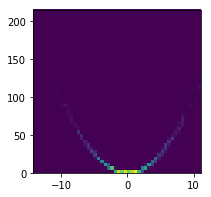

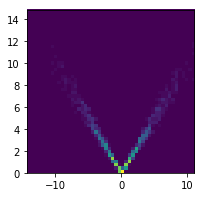

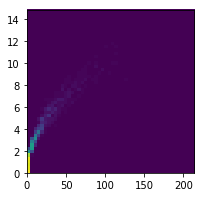

In [4]:
#
# draw 2d correlation
#

print " data_vector = ", data_vector

for i in xrange(dimension_input): 
  for j in xrange(i+1, dimension_input): 
    print " [", i, "][", j, "]"
    fig = plt.figure(figsize = (3,3))  
    plt.hist2d( data_vector[:,i], data_vector[:,j], bins = 50)




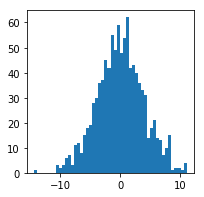

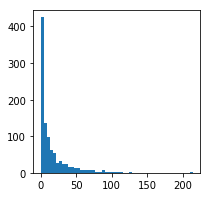

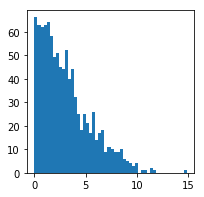

In [5]:
#
# draw 1d
#



for i in range(dimension_input): 
  fig = plt.figure(figsize = (3,3))  
  plt.hist( data_vector[:,i], bins = 50)


    

In [6]:
#
#
#
# Keras model
#
#

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

original_dim = dimension_input
# intermediate_dim = dimension_input/2
intermediate_dim = 10
latent_dim = 3
batch_size = 100
epochs = 200
epsilon_std = 0.1    # 1.0





Using TensorFlow backend.


In [7]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    #
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    #
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    #
    # See: https://keras.io/losses/
    # Cross entropy: https://en.wikipedia.org/wiki/Cross_entropy
    #


In [26]:

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        #
        # var = variance
        #
        # print " mu = ", mu
        # print " log_var = ", log_var
        
        
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [9]:
#
# definition of the decoder
#

decoder = Sequential ([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
    ])



In [10]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#
# h intermediate step
#
#  - mu = mean
#  - var = variance
#
# explanation see: http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
#

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#
# from h -> 2 layers
#

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

#
# Add a new layer that takes "t" and does "exp(0.5 * t)", and apply it to "z_log_var"
# See here for more details: https://keras.io/layers/core/
#

eps = Input (tensor = K.random_normal( stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim) ) )

z_eps = Multiply()([z_sigma, eps])
#
# Layer that multiplies (element-wise) a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

z = Add()([z_mu, z_eps])
#
# Layer that adds a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

x_pred = decoder(z)


In [11]:

vae = Model ( inputs=[x, eps], outputs=x_pred)
vae.compile (optimizer='rmsprop', loss=nll)


In [12]:

# train the VAE 
x_train = data_vector
x_test  = data_vector


history = vae.fit(x_train,   # source
                  x_train,   # target --> autoencoder, then the target is the same as the input
                  shuffle = True,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_test, x_test))    # target = input also in the testing


Train on 1000 samples, validate on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 0s 336us/step - loss: -31.0146 - val_loss: -58.7980
Epoch 2/200
1000/1000 [==============================] - 0s 36us/step - loss: -50.1629 - val_loss: -61.4652
Epoch 3/200
1000/1000 [==============================] - 0s 47us/step - loss: -73.6254 - val_loss: -78.7186
Epoch 4/200
1000/1000 [==============================] - 0s 37us/step - loss: -98.7656 - val_loss: -102.8537
Epoch 5/200
1000/1000 [==============================] - 0s 64us/step - loss: -129.4542 - val_loss: -125.1729
Epoch 6/200
1000/1000 [==============================] - 0s 69us/step - loss: -140.2987 - val_loss: -145.3804
Epoch 7/200
1000/1000 [==============================] - 0s 41us/step - loss: -158.4163 - val_loss: -169.9013
Epoch 8/200
1000/1000 [==============================] - 0s 73us/step - loss: -175.2498 - val_loss: -181.5759
Epoch 9/200
1000/1000 [==============================] - 0s 40us/step - loss: 

1000/1000 [==============================] - 0s 40us/step - loss: -291.4266 - val_loss: -292.0654
Epoch 75/200
1000/1000 [==============================] - 0s 40us/step - loss: -292.5900 - val_loss: -293.2645
Epoch 76/200
1000/1000 [==============================] - 0s 75us/step - loss: -293.6872 - val_loss: -294.2585
Epoch 77/200
1000/1000 [==============================] - 0s 37us/step - loss: -294.5376 - val_loss: -295.0037
Epoch 78/200
1000/1000 [==============================] - 0s 70us/step - loss: -295.2849 - val_loss: -295.7129
Epoch 79/200
1000/1000 [==============================] - 0s 72us/step - loss: -295.9379 - val_loss: -296.2901
Epoch 80/200
1000/1000 [==============================] - 0s 38us/step - loss: -296.5230 - val_loss: -296.8054
Epoch 81/200
1000/1000 [==============================] - 0s 71us/step - loss: -297.0257 - val_loss: -297.2664
Epoch 82/200
1000/1000 [==============================] - 0s 37us/step - loss: -297.5462 - val_loss: -297.8188
Epoch 83/200
1

1000/1000 [==============================] - 0s 92us/step - loss: -304.2903 - val_loss: -304.2991
Epoch 148/200
1000/1000 [==============================] - 0s 39us/step - loss: -304.3029 - val_loss: -304.3152
Epoch 149/200
1000/1000 [==============================] - 0s 60us/step - loss: -304.3155 - val_loss: -304.3261
Epoch 150/200
1000/1000 [==============================] - 0s 79us/step - loss: -304.3291 - val_loss: -304.3385
Epoch 151/200
1000/1000 [==============================] - 0s 35us/step - loss: -304.3416 - val_loss: -304.3501
Epoch 152/200
1000/1000 [==============================] - 0s 81us/step - loss: -304.3549 - val_loss: -304.3617
Epoch 153/200
1000/1000 [==============================] - 0s 84us/step - loss: -304.3637 - val_loss: -304.3686
Epoch 154/200
1000/1000 [==============================] - 0s 36us/step - loss: -304.3709 - val_loss: -304.3766
Epoch 155/200
1000/1000 [==============================] - 0s 71us/step - loss: -304.3782 - val_loss: -304.3821
Epoch 

2019-01-08 14:00:55.188487: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [17]:
encoder = Model(x, z_mu)



In [18]:

# display a plot of the latent space
z_test = encoder.predict(x_test, batch_size = batch_size)



In [19]:
print "z_test = ", z_test

print "x_test = ", x_test



z_test =  [[-0.1346462   1.4548999   9.440905  ]
 [45.815372   59.436592    4.0919585 ]
 [12.611664   23.607979   48.072414  ]
 ...
 [-0.4281396   0.90532506  5.939952  ]
 [ 0.5330279   3.4351768  17.476595  ]
 [26.260818   33.715157   -1.3821865 ]]
x_test =  [[ 1.88574065  3.70088392  2.0277744 ]
 [-4.76390278 23.19451147  5.19970497]
 [ 5.73082787 32.12917962  5.94821477]
 ...
 [ 1.31012932  1.75603901  1.10757908]
 [ 2.9632552   8.70097368  2.60543415]
 [-3.20762019 10.5660694   3.29281688]]


latent layer


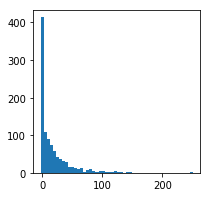

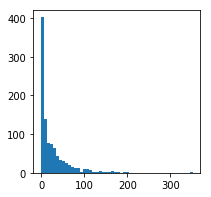

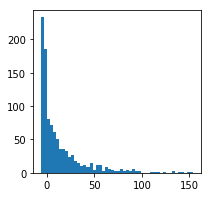

In [20]:
#plt.hist( z_test[:,0], bins = 50)
#plt.hist( x_test[:,0], bins = 50)


print "latent layer"

for inode in range(latent_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( z_test[:,inode], bins = 50)




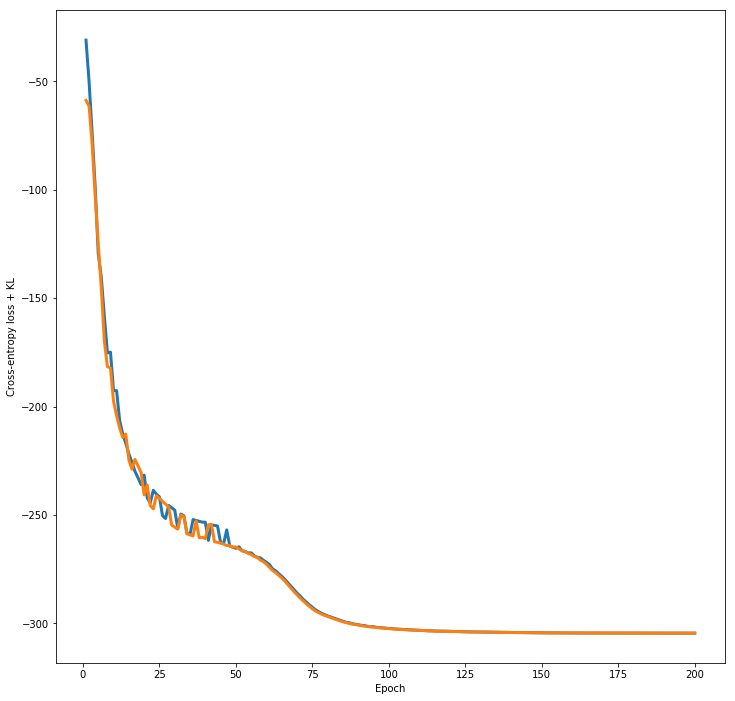

In [21]:


#########################################################
## validation plot

fig_validation = plt.figure(original_dim+latent_dim, figsize=(12,12))

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Epoch"), plt.ylabel("Cross-entropy loss + KL");

# print(history.history)


In [22]:

#########################################################
## plot structure of NN

from keras.utils import plot_model, print_summary
print_summary(vae)

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           40          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 3)            33          dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3)            33          dense_3[0][0]                    
__________________________________________________________________________________________________
kl_diverge

2D: reg vs original


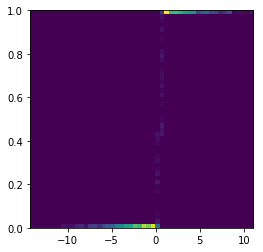

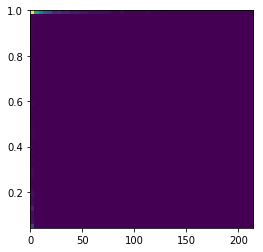

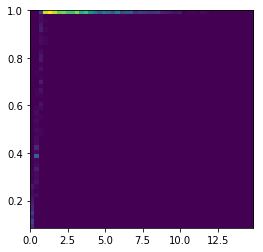

In [23]:
print "2D: reg vs original"

x_reg_test = vae.predict(x_test, batch_size = batch_size)

for inode in range(original_dim):
  fig = plt.figure(figsize = (4,4))
  plt.hist2d( x_test[:,inode], x_reg_test[:,inode], bins = 50)
    
    

input


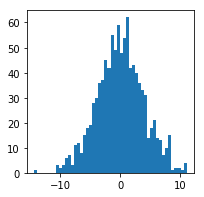

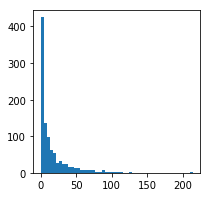

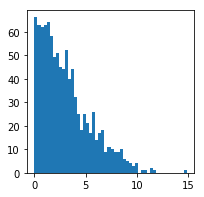

In [24]:

print "input"

for inode in range(original_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( x_test[:,inode], bins = 50)


output


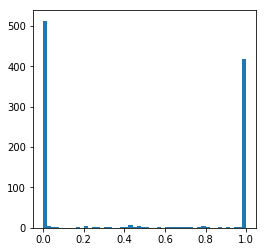

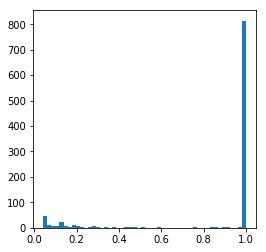

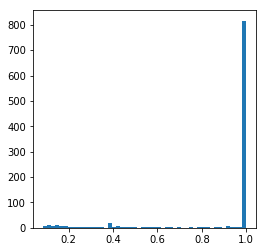

In [25]:
print "output"

for inode in range(original_dim):
   fig = plt.figure(figsize = (4,4))
   plt.hist( x_reg_test[:,inode], bins = 50)
